# Import

## library

In [1]:
import os 
import operator
from tensorflow.python.client import device_lib

device_lib.list_local_devices()

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ["CUDA_VISIBLE_DEVICES"] = ""

import numpy as np
import pandas as pd
import math
from glob import glob
from tqdm import tqdm
from pandas.tseries.offsets import DateOffset
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

import warnings
warnings.filterwarnings(action='ignore')

import seaborn as sns 
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
import matplotlib.cm as cm
from IPython.display import set_matplotlib_formats

sns.set(style='white', context='notebook', palette='deep')
line_color = ['#FFBF00','#FF7F50','#DE3163','#9FE2BF','#40E0D0','#6495ED','#117A65','#2471A3','#CCCCFF','#8E44AD','#CD5C5C' ,'#F08080','#FA8072' ,'#E9967A' ,'#FFA07A']
plt.style.use('fivethirtyeight')
plt.style.use("seaborn-white")
plt.rcParams['font.family'] = 'Malgun Gothic'
matplotlib.rcParams['axes.unicode_minus'] = False
#print(plt.rcParams['font.family'])
%matplotlib inline

In [2]:

#? 파이프라인
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline

#? scaler
from sklearn.preprocessing import MinMaxScaler 
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler


#? 통계
#import statsmodels.api as sm
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from scipy.stats import mstats
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.decomposition import PCA

#? 평가지표
import hydroeval as he
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

#?모델 
import lazypredict
from lazypredict.Supervised import LazyRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import train_test_split

#?모델링 
import joblib
import optuna
from optuna import Trial
from optuna.samplers import TPESampler
from sklearn.inspection import permutation_importance

In [3]:
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
            logical_gpus = tf.config.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)
from tensorflow.python.client import device_lib
device_lib.list_local_devices()



1 Physical GPUs, 1 Logical GPUs


[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 9521844143010561413
 xla_global_id: -1,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 10069475328
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 3255294510092121256
 physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3060, pci bus id: 0000:01:00.0, compute capability: 8.6"
 xla_global_id: 416903419]

## function

In [4]:
# 예측과 실제 수위를 scatter plot해주는 함수 
def scatter_plot(pred,answer):
    x = pred
    y = answer

    fig, axes = plt.subplots(1, 1, figsize=(7, 7))
    rmse,nse,r2=metric(y,x)
    axes.scatter(x, y, label='data') 
    lims = [np.min([axes.get_xlim(), axes.get_ylim()]), np.max([axes.get_xlim(), axes.get_ylim()]), ]
    axes.plot(lims, lims, 'k--', alpha=0.75, zorder=0, label='parity')
    axes.set_aspect('equal')
    axes.set_xlabel('Prediction',fontsize=25)
    axes.set_ylabel('Observation',fontsize=25)
    handles, labels = axes.get_legend_handles_labels()
    txt1="(a)   Jamsu bridge RMSE %.4f"%rmse
    axes.set_title(txt1, fontsize=25,loc='left')
    axes.xaxis.set_tick_params(labelsize=20)
    axes.yaxis.set_tick_params(labelsize=20)

    return fig

In [5]:
# 파일이 존재하는지 확인하는 함수 
def check(filepath):
    csv_files = glob(os.path.join(filepath, "*.csv"))
    if len(csv_files) > 0:return 1
    else:return 0
    
# 그래프에 rmse를 표시해주는 함수 
def plot_rmse(ax, answer, preds, label):
        ax.text(1.0, 0.95, '  {:.3f}  '.format(metric(answer,preds)[0]),
                fontsize=93, ha='right', va='top', transform=ax.transAxes)
        
# rmse와 nse를 계산해주는 함수(m단위)
def metric(y_true, y_pred):
    y_true=y_true/100
    y_pred=y_pred/100
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    nse=he.evaluator(he.nse, y_pred, y_true)
    return rmse,nse,r2

In [6]:
# 선행시간, 이동평균, 윈도우에 맞게 데이터셋을 제공 
def load_dataset2(leadtime,moving_average,version):
    
    # 이동평균을 적용할 feature들 
    select_features=['cd_br','hj_br','jn_br','tl_gh_br','flow','water','wl_js_br']
    # feature engineering 할 유량들.
    fe_list=['cd_br','hj_br','jn_br']
    
    x=pd.concat([train_data,test_data],axis=0)
    x.reset_index(drop=True,inplace=True)
    x=x.set_index('ymdhm')
    x.index=pd.to_datetime(x.index)
    
    
    # 선행시간을 적용하기 위해 타겟을미뤄줌 
    y=x['target'].shift(-leadtime)
    x.drop('target',axis=1,inplace=True)
    
    # feature engineer을 안함(유량정보없음)
    if(version==0):
        x.drop(['fw_cd_br','fw_hj_br','fw_jn_br'],axis=1,inplace=True)
    # feature engineering 함(유량정보있고, 팔당댐도 엔지니어링)
    if(version==1):
        # feature engineering한 버전
        # x['otfinf']=x['tototf_pd_dam']-x['inf_pd_dam']
        x.drop([ 'ecpc_pd_dam'],axis=1,inplace=True)
        
        # 월과 시간에 대한 feature도 추가해줌 
        x['month'],x['hour']=x.index.month,x.index.hour
        
        #! 유량 컬럼의 상관관계가 높아, 
        #! 이전시간과의 유량차이 column을 추가 
        
        flow = PCA(n_components=1)
        flow.fit(x[['tototf_pd_dam','inf_pd_dam']])
        transformed_data = flow.transform(x[['tototf_pd_dam','inf_pd_dam']])  # 변환된 데이터
        x['flow']=transformed_data
        
        water = PCA(n_components=1)
        water.fit(x[['sfw_pd_dam','wl_pd_dam']])
        transformed_data = water.transform(x[['sfw_pd_dam','wl_pd_dam']])  # 변환된 데이터
        x['water']=transformed_data
        
        x.drop(['tototf_pd_dam','inf_pd_dam','sfw_pd_dam','wl_pd_dam'],axis=1,inplace=True)
        
        fe_list=['cd_br','hj_br','jn_br']
        for i in fe_list:
            v_name = f"{i}_pca"  # 동적으로 생성할 변수명
            f_name,w_name = "fw_"+i, 'wl_'+i
            tmp=x[[f_name,w_name]]
            globals()[v_name] = PCA(n_components=1)  # 변수 생성
            globals()[v_name].fit(tmp)  # PCA 수행
            transformed_data = globals()[v_name].transform(tmp)  # 변환된 데이터
            x[i]=transformed_data
            x.drop([f_name],axis=1,inplace=True)
            if(moving_average<1): x.drop([w_name],axis=1,inplace=True)
       
    
    # 이동평균을 적용
    if(moving_average>1):
        for i in range(len(select_features)):
            coln=select_features[i]+str(moving_average)+'ma'
            x[coln] = x[select_features[i]].rolling(window=moving_average).mean()
            if(i<3):x.drop('wl_'+select_features[i],axis=1,inplace=True)
            
        
    # train과 test를 다시 분리       
    idx = x.index.get_loc('2022-06-21 00:00:00')
    
    # test를 위해 train과 test의 범위를 선행시간만큼 조정 
    x_train=x[:idx-leadtime]
    x_test=x[idx-leadtime:]
    y_train = y[:idx - leadtime]
    
    if(version==1 and moving_average==0):
        x_train=x_train[1:]
        y_train=y_train[1:]

    # 이동평균을 적용하면 생기는 nan을 없애주기 위함 
    if(moving_average!=0):
        x_train=x_train[moving_average:]
        y_train=y_train[moving_average:]
        
    dataset=[x_train,x_test,y_train]
    
    return dataset

In [7]:
# 선행시간, 이동평균, 윈도우에 맞게 데이터셋을 제공 
def load_dataset(leadtime,moving_average,version):
    
    # 이동평균을 적용할 feature들 
    select_features=['wl_js_br','wl_cd_br','wl_hj_br','wl_jn_br','wl_pd_dam','tl_gh_br']
    # feature engineering 할 유량들.
    fe_list=['cd_br','hj_br','jn_br']
    
    x=pd.concat([train_data,test_data],axis=0)
    x.reset_index(drop=True,inplace=True)
    x=x.set_index('ymdhm')
    x.index=pd.to_datetime(x.index)
    
    # 선행시간을 적용하기 위해 타겟을미뤄줌 
    y=x['target'].shift(-leadtime)
    x.drop('target',axis=1,inplace=True)
    
    # feature engineer을 안함(유량정보없음)
    if(version==0):
        x.drop(['fw_cd_br','fw_hj_br','fw_jn_br'],axis=1,inplace=True)
    # feature engineering 함(유량정보있고, 팔당댐도 엔지니어링)
    if(version==1):
        # feature engineering한 버전
        x['otfinf']=x['tototf_pd_dam']-x['inf_pd_dam']
        x.drop([ 'inf_pd_dam','ecpc_pd_dam', 'tototf_pd_dam'],axis=1,inplace=True)
        
        # 월과 시간에 대한 feature도 추가해줌 
        x['month'],x['hour']=x.index.month,x.index.hour
        
        #! 유량 컬럼의 상관관계가 높아, 
        #! 이전시간과의 유량차이 column을 추가 
        for i in fe_list:
            name1='fw_'+i
            name2='fw_'+i+'_lag'

            x[name2]= x[name1] - x[name1].shift(1)
            x.drop(name1,axis=1,inplace=True)
            
    # 이동평균을 적용
    if(moving_average>1):
        for i in range(len(select_features)):
            coln=select_features[i]+str(moving_average)+'ma'
            x[coln] = x[select_features[i]].rolling(window=moving_average).mean()
        
    # train과 test를 다시 분리       
    idx = x.index.get_loc('2022-06-21 00:00:00')
    
    # test를 위해 train과 test의 범위를 선행시간만큼 조정 
    x_train=x[:idx-leadtime]
    x_test=x[idx-leadtime:]
    y_train = y[:idx - leadtime]
    
    if(version==1 and moving_average==0):
        x_train=x_train[1:]
        y_train=y_train[1:]

    # 이동평균을 적용하면 생기는 nan을 없애주기 위함 
    if(moving_average!=0):
        x_train=x_train[moving_average:]
        y_train=y_train[moving_average:]
        
    dataset=[x_train,x_test,y_train]
    
    return dataset

In [8]:
# 선행시간, 이동평균, 윈도우에 맞게 데이터셋을 제공 
def load_dataset3(leadtime,moving_average,version):
    
    # 이동평균을 적용할 feature들 
    select_features=['wl_js_br','wl_cd_br','wl_hj_br','wl_jn_br','wl_pd_dam','tl_gh_br']
    # feature engineering 할 유량들.
    fe_list=['cd_br','hj_br','jn_br']
    
    x=pd.concat([train_data,test_data],axis=0)
    x.reset_index(drop=True,inplace=True)
    x=x.set_index('ymdhm')
    x.index=pd.to_datetime(x.index)
    
    # 선행시간을 적용하기 위해 타겟을미뤄줌 
    y=x['target'].shift(-leadtime)
    x.drop('target',axis=1,inplace=True)
    
    # feature engineer을 안함(유량정보없음)
    if(version==0):
        x.drop(['fw_cd_br','fw_hj_br','fw_jn_br'],axis=1,inplace=True)
    # feature engineering 함(유량정보있고, 팔당댐도 엔지니어링)
    if(version==1):
        # feature engineering한 버전
        x['otfinf']=x['tototf_pd_dam']-x['inf_pd_dam']
        x.drop([ 'inf_pd_dam','ecpc_pd_dam', 'tototf_pd_dam'],axis=1,inplace=True)
        
        # 월과 시간에 대한 feature도 추가해줌 
        x['month'],x['hour']=x.index.month,x.index.hour
        
        #! 유량 컬럼의 상관관계가 높아, 
        #! 이전시간과의 유량차이 column을 추가 
    # 이동평균을 적용
    if(moving_average>1):
        for i in range(len(select_features)):
            coln=select_features[i]+str(moving_average)+'ma'
            x[coln] = x[select_features[i]].rolling(window=moving_average).mean()
        
    # train과 test를 다시 분리       
    idx = x.index.get_loc('2022-06-21 00:00:00')
    
    # test를 위해 train과 test의 범위를 선행시간만큼 조정 
    x_train=x[:idx-leadtime]
    x_test=x[idx-leadtime:]
    y_train = y[:idx - leadtime]
    
    if(version==1 and moving_average==0):
        x_train=x_train[1:]
        y_train=y_train[1:]

    # 이동평균을 적용하면 생기는 nan을 없애주기 위함 
    if(moving_average!=0):
        x_train=x_train[moving_average:]
        y_train=y_train[moving_average:]
        
    dataset=[x_train,x_test,y_train]
    
    return dataset

In [9]:
def create_model(filepath,epoch,base_set):
    
    print("Modeling Start*******")
    # optuna 학습 
    study_model = optuna.create_study(direction='minimize', sampler=sampler)
    
    # early-stopping callback 추가
    early_stopping = EarlyStoppingCallback(15, direction='minimize')
    study_model.optimize(objective_randomforest, epoch, callbacks=[early_stopping])
    
    # optuna 학습결과 파라미터 가져오기
    trial = study_model.best_trial
    trial_params = trial.params
    print(" Value: ", trial.value)
    print(" Params: ")
    for key, value in trial_params.items():
        print(f"    {key}: {value}")
        
    # optuna로 학습된 파라미터로 모델 재 학습 
    model = RandomForestRegressor(**trial_params,random_state=624,) # 최적화된 파라미터를 통해 학습 
    model.fit(base_set[0], base_set[2]) 
    pred = model.predict(base_set[1])
    pred=pd.DataFrame(pred,columns=['wl_js_br'])
    pred = pred[:-1] # 선행시간 10분에 따라 미뤄줌 
    
    return pred,study_model

In [10]:
sampler = TPESampler(seed=10)

def objective_randomforest(trial):
    
    rf_param = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 1000),
        'max_depth': trial.suggest_int('max_depth', 4, 50),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 150),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 2, 60),
        'n_jobs':-1
    }
    X_train, X_valid, y_train, y_valid = train_test_split(base_set[0], base_set[2], test_size=0.3, random_state=624)
    
    model = RandomForestRegressor(random_state=624, **rf_param)
    model.fit(X_train,y_train)
    
    rmse = np.sqrt(mean_squared_error(y_valid, model.predict(X_valid)))
    
    return rmse

In [11]:
class EarlyStoppingCallback(object):
    
    # 평가지수가 감소하는 방향으로 학습하면 minimize
    # 평가지수가 증가하는 방향으로 학습하면 maximize

    def __init__(self, early_stopping_rounds: int, direction: str = "minimize") -> None:
        self.early_stopping_rounds = early_stopping_rounds

        self._iter = 0

        if direction == "minimize":
            self._operator = operator.lt
            self._score = np.inf
        elif direction == "maximize":
            self._operator = operator.gt
            self._score = -np.inf
        else:
            ValueError(f"invalid direction: {direction}")

    def __call__(self, study: optuna.Study, trial: optuna.Trial) -> None:
        """Do early stopping."""
        if self._operator(study.best_value, self._score):
            self._iter = 0
            self._score = study.best_value
        else:
            self._iter += 1

        if self._iter >= self.early_stopping_rounds:
            study.stop()

# Data Load and Preprocessing

## Origin data load

In [ ]:
data=pd.read_csv("../data/full_data.csv")
train_data=pd.read_csv("../data/train_data.csv")
test_data=pd.read_csv("../data/test_data.csv")

## data preprocessing

In [ ]:
train_data = train_data.set_index(['ymdhm'],drop=True)
train_data.index=pd.to_datetime(train_data.index)
train_data=train_data.replace('##########',np.nan)
train_data=train_data.replace(' ',np.nan)
train_data=train_data.astype('float')
train_data.drop(['fw_js_br'],axis=1,inplace=True)
train_data.drop(['fw_gj_br'],axis=1,inplace=True)

test_data = test_data.set_index(['ymdhm'],drop=True)
test_data.index=pd.to_datetime(test_data.index)
test_data=test_data.replace('##########',np.nan)
test_data=test_data.replace(' ',np.nan)
test_data=test_data.astype('float')
test_data.drop(['fw_js_br'],axis=1,inplace=True)
test_data.drop(['fw_gj_br'],axis=1,inplace=True)

In [ ]:
rf_list=['pr_jg','pr_dg','pr_sj']
wl_list=['wl_js_br','wl_cd_br','wl_hj_br','wl_hg_br','wl_gj_br','wl_pd_br','wl_jn_br']

for col in train_data.columns:
    if(col not in rf_list):
        q1 = train_data[col].quantile(0.005)
        train_data[col][train_data[col]<q1]=np.nan
        if(col not in wl_list):
            q99 = train_data[col].quantile(0.995)
            train_data[col][train_data[col]>q99]=np.nan

    train_data[col] = train_data[col].interpolate(method='time')
train_data['wl_gj_br'] = mstats.winsorize(train_data['wl_gj_br'], limits=[0.01, 0.01])

In [ ]:
rf_list=['pr_jg','pr_dg','pr_sj']
wl_list=['wl_js_br','wl_cd_br','wl_hj_br','wl_hg_br','wl_gj_br','wl_pd_br','wl_jn_br']

for col in test_data.columns:
    if(col not in rf_list):
        q1 = test_data[col].quantile(0.005)
        test_data[col][test_data[col]<q1]=np.nan
        if(col not in wl_list):
            q99 = test_data[col].quantile(0.995)
            test_data[col][test_data[col]>q99]=np.nan
test_data['wl_gj_br'] = mstats.winsorize(test_data['wl_gj_br'], limits=[0.01, 0.01])

data=pd.concat([train_data,test_data],axis=0)

idx = data.loc[data.isna().any(axis=1)].index
idx=idx.unique()
for i in tqdm(idx):
    tmp=data[:i]
    tmp=tmp.interpolate(method='time')
    for j in data.columns:
        if pd.isna(data.loc[i, j]):
            data.loc[i][j]=tmp.iloc[-1][j]
idx = data.index.get_loc('2022-06-21 00:00:00')
test_data=data[idx:]
test_data.info()

In [ ]:
train_data=train_data[['wl_js_br', 'wl_cd_br', 'wl_hj_br','wl_hg_br', 'wl_gj_br','wl_pd_br','wl_jn_br',
                       'fw_cd_br', 'fw_hj_br', 'fw_hg_br', 'fw_pd_br','fw_jn_br',  
                       'wl_pd_dam','inf_pd_dam', 'sfw_pd_dam', 'ecpc_pd_dam', 'tototf_pd_dam', 
                       'pr_jg','pr_dg', 'pr_sj', 'tl_gh_br', ]]
test_data=test_data[['wl_js_br', 'wl_cd_br', 'wl_hj_br','wl_hg_br', 'wl_gj_br','wl_pd_br','wl_jn_br',
                       'fw_cd_br', 'fw_hj_br', 'fw_hg_br', 'fw_pd_br','fw_jn_br',  
                       'wl_pd_dam','inf_pd_dam', 'sfw_pd_dam', 'ecpc_pd_dam', 'tototf_pd_dam', 
                       'pr_jg','pr_dg', 'pr_sj', 'tl_gh_br', ]]

In [ ]:
train_data.to_csv("data/refined_train_data.csv",index=False)
test_data.to_csv("data/refined_test_data.csv",index=False)

# Refined data load

In [12]:
data=pd.read_csv("../data/new_Refined_data.csv")
train_data=pd.read_csv("../data/refined_train_data.csv")
test_data=pd.read_csv("../data/refined_test_data.csv")
answer=pd.read_csv("../data/answer.csv")

train_data['target']=train_data['wl_js_br']
test_data['target']=0
# answer

train_data.drop(['wl_hg_br','fw_hg_br','wl_gj_br','wl_pd_br','fw_pd_br'],axis=1,inplace=True)
test_data.drop(['wl_hg_br','fw_hg_br','wl_gj_br','wl_pd_br','fw_pd_br'],axis=1,inplace=True)

In [13]:
x,y=[],[]
data=load_dataset2(0,0,1)
data[0].reset_index(drop=True,inplace=True)
data[1].reset_index(drop=True,inplace=True)
data[2].reset_index(drop=True,inplace=True)
features=['wl_js_br', 'pr_jg', 'pr_dg', 'pr_sj', 'tl_gh_br', 'month', 'hour',
       'flow', 'water', 'cd_br', 'hj_br', 'jn_br']
for i in tqdm(range(len(data[0])-6)):
    x.append(np.array(data[0].loc[i:i+5, features]).astype(float))
    y.append(np.array(data[2].loc[i+6]).astype(float))
x_train = np.array(x)
y_train = np.array(y)

100%|██████████| 497945/497945 [02:56<00:00, 2824.64it/s]


In [14]:
x=[]
for i in tqdm(range(len(data[1])-6)):
    x.append(np.array(data[1].loc[i:i+5, features]).astype(float))
x_test = np.array(x)

100%|██████████| 13242/13242 [00:04<00:00, 2926.65it/s]


In [15]:
x_train.shape

(497945, 6, 12)

In [17]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, LSTM, GRU, AveragePooling1D, GlobalAveragePooling1D
from tensorflow.compat.v1.keras.backend import get_session
tf.compat.v1.disable_v2_behavior()

input_shape = (x_train[0].shape[0], x_train[0].shape[1])

model = Sequential()
model.add(LSTM(256, input_shape=(6,12)))
model.add(Dense(1, activation='relu'))

optimizer = tf.optimizers.RMSprop(0.001)

model.compile(optimizer=optimizer,loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError()])

Instructions for updating:
non-resource variables are not supported in the long term


In [18]:
model.fit(x_train, y_train, epochs=1, batch_size=128)

Train on 497945 samples
497945/497945 [==============================] - 16s 31us/sample - loss: 9433.6841 - root_mean_squared_error: 97.1271


In [19]:
y_pred=model.predict(x_test)

In [20]:
from tensorflow.keras.models import load_model

model.save('lstm_model(1).h5')

In [21]:
y_pred=pd.DataFrame(y_pred)

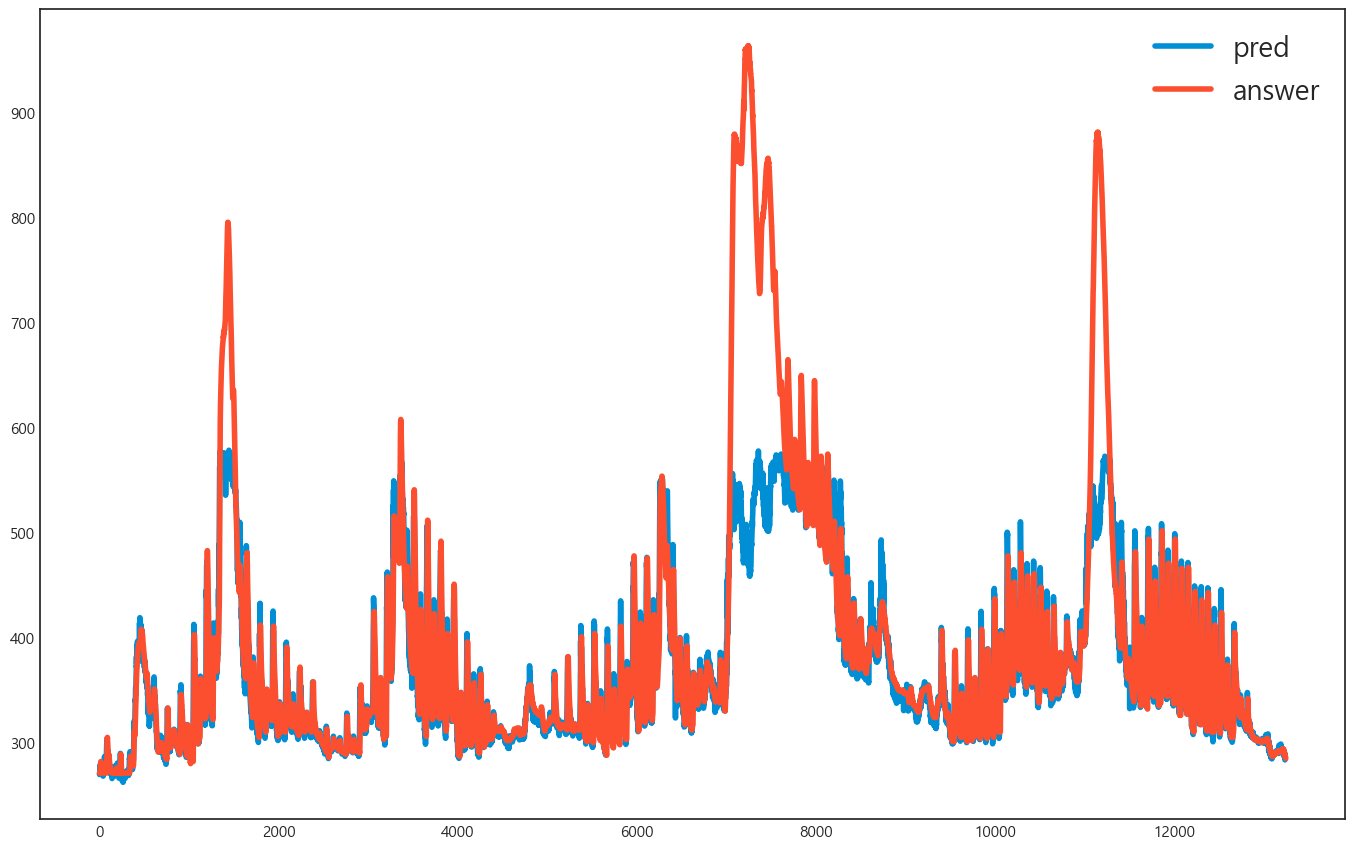

In [22]:
fig=plt.figure(figsize=(15,10))
plt.plot(y_pred) # 선행시간 10m
plt.plot(answer) # 선행시간 30m
plt.legend(['pred','answer'],fontsize=20)
plt.show();

In [36]:
import shap

# we use the first 100 training examples as our background dataset to integrate over
explainer = shap.DeepExplainer(model, x_train[:100])
# explain the first 10 predictions
# explaining each prediction requires 2 * background dataset size runs
shap_values = explainer.shap_values(x_test[:10],check_additivity=False)

shap.image_plot(shap_values, -x_test[1:5])

AttributeError: 'Deep' object has no attribute 'masker'

In [34]:
shap.plots.bar(explainer)

AssertionError: You must pass an Explanation object, Cohorts object, or dictionary to bar plot!

In [24]:
import numpy as np
np.bool = np.bool_
np.int = np.int_

In [23]:
print(np.__version__)

1.24.3


In [24]:
pip install shap==0.41.0

Note: you may need to restart the kernel to use updated packages.
